In [212]:
#pip install scikit-optimize

Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Load the data from the cleaned data source file

In [22]:
#Load dataset into a pandas dataframe
data = pd.read_csv("Cleaned data/data.csv") 

# don't really need to do this as this is cleaned data
data.dropna(inplace = True)

data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,32.2,21.95,38.472917,6665.366167,23.465,01-2016,4,0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,21.7,21.00,36.907292,6236.849955,23.465,01-2016,5,1
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,10.3,21.55,31.997083,6551.924748,23.465,01-2016,6,1
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,6.4,20.90,33.424583,6729.993123,23.465,01-2016,0,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,4.4,19.05,33.053958,7333.898202,23.465,01-2016,1,0


Drop the un-needed features

In [23]:
# df = data.drop(['MIN','MAX','FORECASTDEMAND', 'MONTHDATE','WEEKEND','RAIN'], axis=1)
df = data.drop(['MIN','MAX', 'MONTHDATE','WEEKEND'], axis=1)
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,WEEKDAY
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,21.95,38.472917,6665.366167,23.465,4
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,21.00,36.907292,6236.849955,23.465,5
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,21.55,31.997083,6551.924748,23.465,6
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,20.90,33.424583,6729.993123,23.465,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,19.05,33.053958,7333.898202,23.465,1


One-hot encoding of categorical variables

In [24]:
# One-hot Encoding for categorial data (Weekday)

# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']]

# Create a one-hot encoder object
encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])

#Drop the weekday column
df = df.drop(['WEEKDAY'], axis=1)

# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df, weekday_df], axis=1)

df.dropna(inplace = True)
df.tail()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
2320,2022.0,6.0,5.0,0.609524,21.928571,2022-06-05,8264.017639,0.0,8.7,12.35,36.572308,8117.157016,143.61,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2321,2022.0,6.0,6.0,0.596500,24.525000,2022-06-06,8739.097918,0.0,11.2,14.00,147.080000,8837.504516,143.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2322,2022.0,6.0,7.0,0.475405,29.675676,2022-06-07,8934.923784,0.0,11.1,10.50,122.986667,9265.507365,143.61,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2323,2022.0,6.0,11.0,0.536667,25.256410,2022-06-11,8505.025104,0.0,11.0,10.00,98.774828,8713.454722,143.61,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2324,2022.0,6.0,12.0,0.526829,27.024390,2022-06-12,8118.189792,0.0,11.0,12.65,94.436000,8412.427616,143.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2355 entries, 2016-01-01 to NaT
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            2325 non-null   float64
 1   MONTH           2325 non-null   float64
 2   DAY             2325 non-null   float64
 3   HUMIDITY        2325 non-null   float64
 4   WINDSPEED       2325 non-null   float64
 5   TOTALDEMAND     2325 non-null   float64
 6   HOLIDAY         2325 non-null   float64
 7   SOLAR           2325 non-null   float64
 8   TEMPAVE         2325 non-null   float64
 9   RRP             2325 non-null   float64
 10  FORECASTDEMAND  2325 non-null   float64
 11  OUTPUT          2325 non-null   float64
 12  MON             2325 non-null   float64
 13  TUE             2325 non-null   float64
 14  WED             2325 non-null   float64
 15  THU             2325 non-null   float64
 16  FRI             2325 non-null   float64
 17  SAT             2325 n

Split the dataset into training and testing sets
<br>Note: 
- training is from August 2017 - July 2021 (inclusive)
- testing is from August 2021 - July 2022 (inclusive) 

In [26]:
df_train = df[(df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1))]
df_test = df[df.index >= datetime(2021, 8, 1)]

demand_train_df = df_train[['TOTALDEMAND','FORECASTDEMAND']]
demand_test_df = df_test[['TOTALDEMAND','FORECASTDEMAND']]

df_train.drop(['FORECASTDEMAND'], axis=1)
df_test.drop(['FORECASTDEMAND'], axis=1)

train_X = df_train.drop('TOTALDEMAND', axis=1)
train_y = df_train['TOTALDEMAND']

test_X = df_test.drop('TOTALDEMAND', axis=1)
test_y = df_test['TOTALDEMAND']

print("number of training records",len(train_X))
print("number of test records",len(test_X))

X_train = train_X.values
y_train = train_y.values

X_test = test_X.values
y_test = test_y.values

number of training records 1417
number of test records 304


Normalize the data

In [27]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("X_train_scaled:", len(X_train_scaled))
print("X_test_scaled:", len(X_test_scaled))

scaler_Y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1))

print("y_train_scaled:", len(y_train_scaled))
print("y_test_scaled:", len(y_test_scaled))

X_train_scaled: 1417
X_test_scaled: 304
y_train_scaled: 1417
y_test_scaled: 304


Reshape the data for input to the LSTM model 

In [28]:
#(This step will fit the data to a 3D tensor format for the LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)

#we using sliding window approach to create input-output pairs with
#timesteps n = 1

X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1, :])
    y_train.append(y_train_scaled[i-1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1,:])
    y_test.append(y_test_scaled[i-1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (1416, 18)
y_train:  (1416, 1)
X_test:  (303, 18)
y_test:  (303, 1)


In [29]:
y_test.shape

(303, 1)

We use a Bayesian optimisation process to find the optimum combination of hyperparameters for this model
(Note: we are using the scikit-optimize library) 

In [30]:
# Setting the input and output dimensions and timesteps for the forecast
input_dim = X_train.shape[1]
output_dim = 1
timesteps = 1

# Assuming X_train and X_test are numpy arrays
X_train = X_train.reshape((X_train.shape[0], timesteps, input_dim))
X_test = X_test.reshape((X_test.shape[0], timesteps, input_dim))

print(X_train.shape)
print(X_test.shape)

(1416, 1, 18)
(303, 1, 18)


In [31]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from skopt import gp_minimize
from skopt.space import Real, Integer, Space, Categorical
from skopt.utils import use_named_args

# Define a function to create the LSTM model
def create_lstm_model(lr, n_units1, n_units2, n_units3, dropout_rate1, dropout_rate2, dropout_rate3, activation1, activation2, activation3):
    model = Sequential()
    model.add(LSTM(units=n_units1, input_shape=(timesteps, input_dim), return_sequences=True, activation=activation1))
    model.add(Dropout(dropout_rate1))
    model.add(LSTM(units=n_units2, activation=activation2, return_sequences=True))
    model.add(Dropout(dropout_rate2))
    model.add(LSTM(units=n_units3, activation=activation3))
    model.add(Dropout(dropout_rate3))
    model.add(Dense(output_dim))

    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    
    return model

# Define the function to optimize
@use_named_args([
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units1'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units2'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units3'),
    Integer(0, 5, name='dropout_rate1'),
    Integer(0, 5, name='dropout_rate2'),
    Integer(0, 5, name='dropout_rate3'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation3')
])

def optimize_lstm(learning_rate, 
                  n_units1, n_units2, n_units3,    
                  dropout_rate1, dropout_rate2, dropout_rate3,
                  activation1, activation2, activation3):
    
    dropout_rate1 = dropout_rate1/10
    dropout_rate2 = dropout_rate2/10
    dropout_rate3 = dropout_rate3/10
    
    # Create the model
    model = create_lstm_model(learning_rate, 
                              n_units1, n_units2, n_units3,  
                              dropout_rate1, dropout_rate2, dropout_rate3, 
                              activation1, activation2, activation3)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, batch_size=64, verbose=0, callbacks=[early_stopping])
    
    # Get the validation MAE from the last epoch
    val_mae = history.history['val_mae'][-1]
    
    return val_mae


start_time = time.perf_counter()

# Set up early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Define the search space
search_space = Space([
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units1'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units2'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units3'),
    Integer(0, 5, name='dropout_rate1'),
    Integer(0, 5, name='dropout_rate2'),
    Integer(0, 5, name='dropout_rate3'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation3')
])

# Run the Bayesian optimisation
result = gp_minimize(optimize_lstm, search_space, n_calls=50, random_state=42)

# extract the best hyperparameters
best_learning_rate, best_n_units1, best_n_units2, best_n_units3, best_dropout_rate1, best_dropout_rate2, best_dropout_rate3, best_activation1, best_activation2, best_activation3  = result.x

end_time = time.perf_counter()

print(f"Bayesian Optimisation time: {end_time - start_time:0.4f} seconds")

Bayesian Optimisation time: 2338.5046 seconds


In [33]:
best_dropout_rate1 = best_dropout_rate1/10
best_dropout_rate2 = best_dropout_rate2/10
best_dropout_rate3 = best_dropout_rate3/10

# Print the optimal hyperparameters
print(f"best_learning_rate = {best_learning_rate}")
print(f"best_n_units1 = {best_n_units1}")
print(f"best_n_units2 = {best_n_units2}")
print(f"best_n_units3 = {best_n_units3}")
print(f"best_activation1 = '{best_activation1}'")
print(f"best_activation2 = '{best_activation2}'")
print(f"best_activation3 = '{best_activation3}'")
print(f"best_dropout_rate1 = {best_dropout_rate1}")
print(f"best_dropout_rate2 = {best_dropout_rate2}")
print(f"best_dropout_rate3 = {best_dropout_rate3}")

best_learning_rate = 0.0006272592284987241
best_n_units1 = 1024
best_n_units2 = 1024
best_n_units3 = 256
best_activation1 = 'tanh'
best_activation2 = 'relu'
best_activation3 = 'tanh'
best_dropout_rate1 = 0.01
best_dropout_rate2 = 0.02
best_dropout_rate3 = 0.02


In [12]:
# best_learning_rate = 0.004207799011940952
# best_n_units1 = 784
# best_n_units2 = 1024
# best_n_units3 = 87
# best_n_units4 = 1024
# best_activation1 = 'tanh'
# best_activation2 = 'tanh'
# best_activation3 = 'sigmoid'
# best_activation4 = 'relu'
# best_dropout_rate1 = 0.4
# best_dropout_rate2 = 0.5
# best_dropout_rate3 = 0.2
# best_dropout_rate4 = 0.0

Build the final LSTM model with the optimal hyperparameters selected

In [34]:
# setup the model 
timesteps=X_train.shape[1]
input_dim=X_train.shape[2]
output_dim=1

# Build the LSTM model with 1 input layer, 2 hidden LSTM layers and one Dense output layer
# using the best combination of hyperparameters as derived above
model = Sequential()
model.add(LSTM(units=best_n_units1, input_shape=(timesteps, input_dim), return_sequences=True, activation=best_activation1))
model.add(Dropout(best_dropout_rate1))
model.add(LSTM(units=best_n_units2, activation=best_activation2, return_sequences=True))
model.add(Dropout(best_dropout_rate2))
model.add(LSTM(units=best_n_units3, activation=best_activation3))
model.add(Dropout(best_dropout_rate3))
model.add(Dense(output_dim))

optimizer=Adam(learning_rate=best_learning_rate)
model.compile(loss='mae', optimizer=optimizer)

In [35]:
#set the model to stop early if it appears to converge (decided on 20 iterations with no changes)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) 

# Train the LSTM model on the olptimum model definition
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
23/23 [==============================] - 7s 153ms/step - loss: 0.2610 - val_loss: 0.1416
Epoch 2/50
23/23 [==============================] - 3s 118ms/step - loss: 0.1385 - val_loss: 0.1904
Epoch 3/50
23/23 [==============================] - 3s 118ms/step - loss: 0.0937 - val_loss: 0.1479
Epoch 4/50
23/23 [==============================] - 3s 118ms/step - loss: 0.0657 - val_loss: 0.0924
Epoch 5/50
23/23 [==============================] - 3s 120ms/step - loss: 0.0517 - val_loss: 0.0452
Epoch 6/50
23/23 [==============================] - 3s 121ms/step - loss: 0.0450 - val_loss: 0.0356
Epoch 7/50
23/23 [==============================] - 3s 122ms/step - loss: 0.0486 - val_loss: 0.0432
Epoch 8/50
23/23 [==============================] - 3s 119ms/step - loss: 0.0437 - val_loss: 0.0321
Epoch 9/50
23/23 [==============================] - 3s 122ms/step - loss: 0.0426 - val_loss: 0.0312
Epoch 10/50
23/23 [==============================] - 3s 120ms/step - loss: 0.0402 - val_loss: 0.0341

Run the prediction on the test set

In [36]:
# Make predictions on the test set
y_pred = model.predict(X_test)

10/10 [==============================] - 1s 8ms/step


In [37]:
# Evaluate the LSTM model on the test set
# Calculate MAE, MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Number of predictions: %d' % len(y_pred))
print('MAE: %.4f' % mae)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

Number of predictions: 303
MAE: 0.0291
MSE: 0.0015
R-squared: 0.9410


Plot the loss function (MAE) against the training and test data 

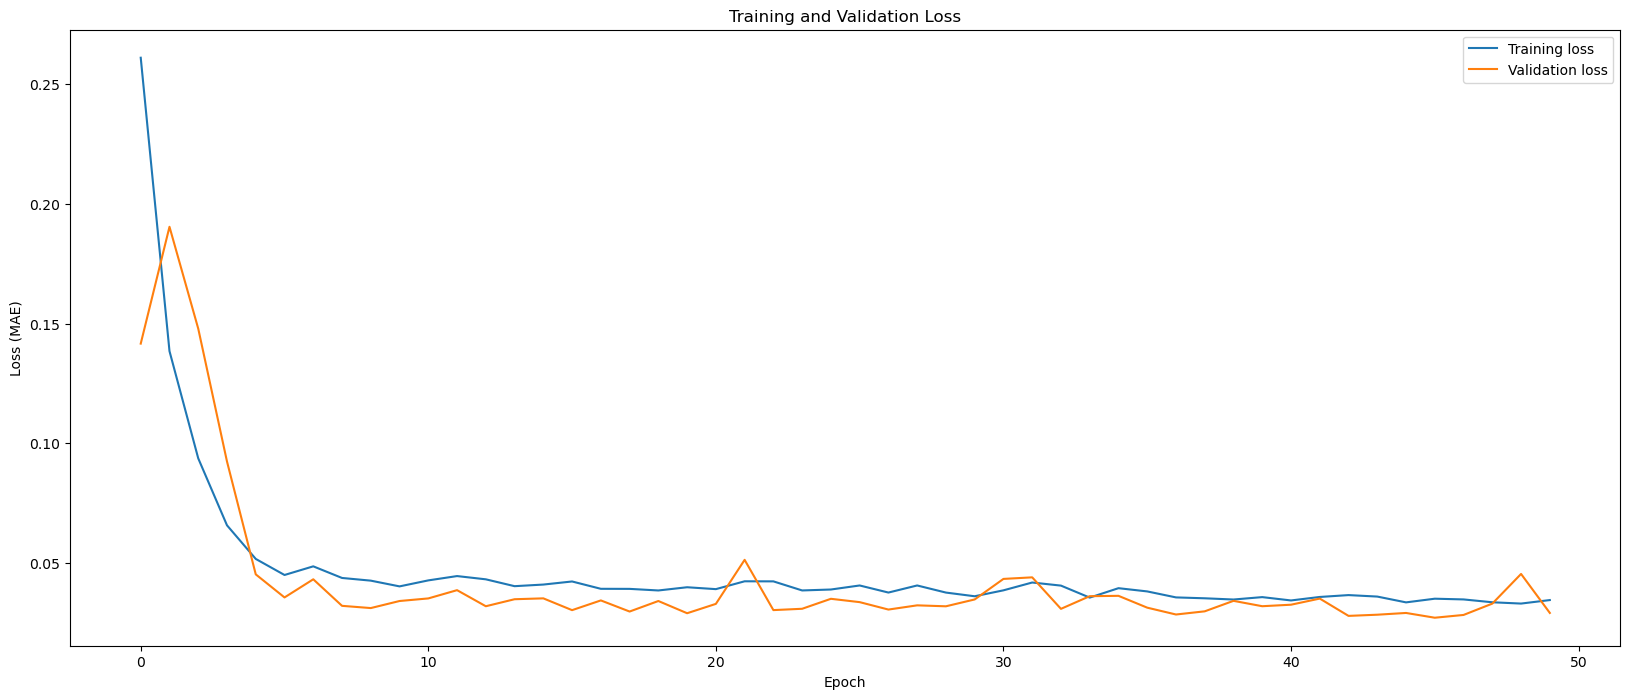

In [38]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [39]:
# revert the predicted values to actual values
y_pred_reverted = scaler_Y.inverse_transform(y_pred)

y_pred_reverted = list(y_pred_reverted.flatten())
y_pred_reverted.insert(0, None)

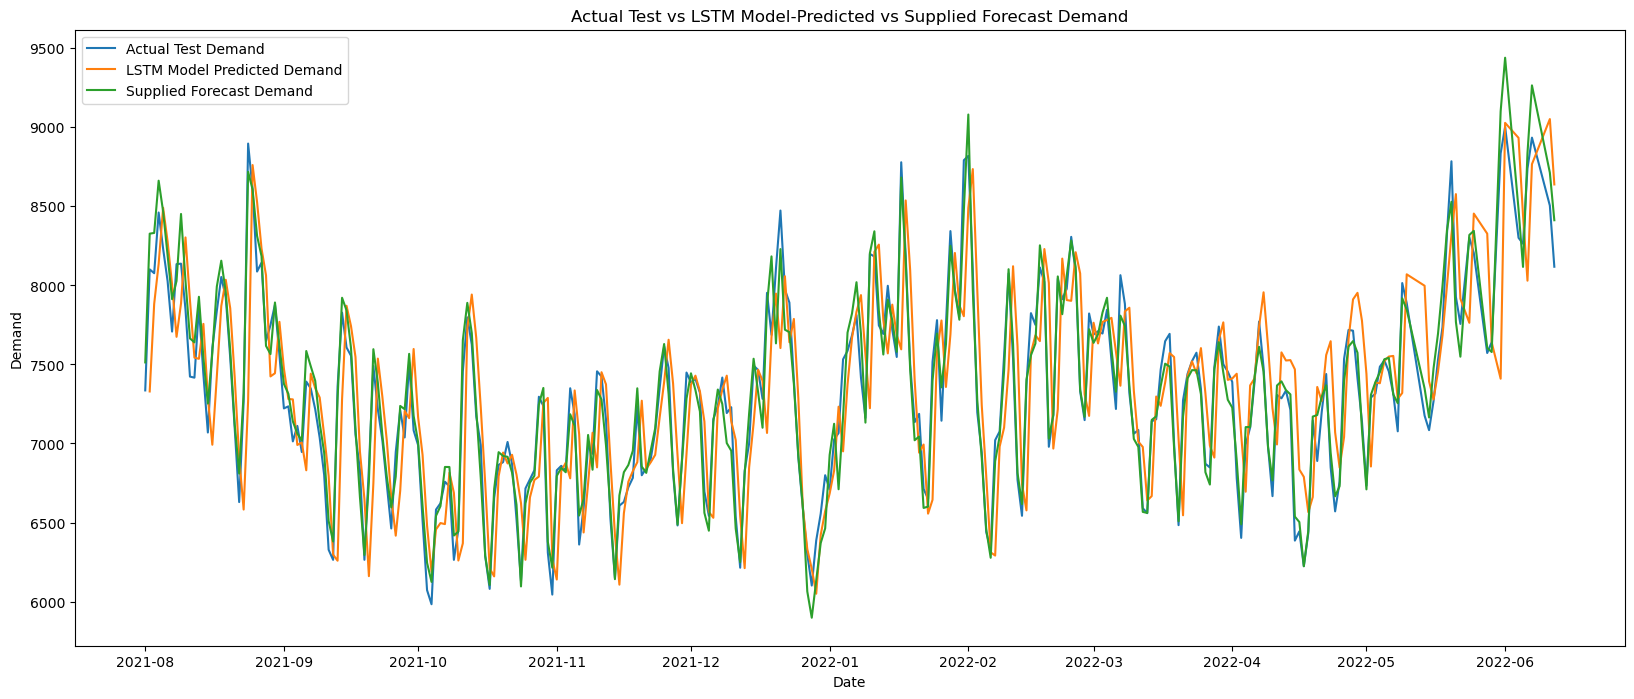

In [40]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(test_set_df.index, test_set_df.TOTALDEMAND, label='Actual Test Demand')
plt.plot(test_set_df.index, test_set_df.Pred_Demand, label='LSTM Model Predicted Demand')
plt.plot(test_set_df.index, test_set_df.FORECASTDEMAND, label='Supplied Forecast Demand')
plt.title('Actual Test vs LSTM Model-Predicted vs Supplied Forecast Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

Comparing the LSTM to the University supplied forecasts

In [56]:
print("LSTM Model Avg Actual Difference: ",(test_set_df.TOTALDEMAND - test_set_df.Pred_Demand)[1:].mean())

print("Supplied Model Avg Actual Difference: ",(test_set_df.TOTALDEMAND - test_set_df.FORECASTDEMAND)[1:].mean())

LSTM Model Avg Actual Difference:  -14.364751503965309
Supplied Model Avg Actual Difference:  -14.60233620998184


Approximation Model

Try a Random Forest Regressor to work out feature importance of the results of the LSTM model

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import set_config 

In [42]:
df_test_copy = df_test.copy()

df_test_copy['Predicted_Demand'] = test_set_df['Pred_Demand']
df_test_copy.drop(columns=['FORECASTDEMAND'], inplace=True)

feature_cols = df_test_copy.columns[:-1]

df_test_copy.dropna(axis=0, inplace=True)
test_training = df_test_copy[(df_test_copy.index >= datetime(2021, 8, 1)) & (df_test_copy.index < datetime(2022, 6, 1))]
test_validation = df_test_copy[df_test_copy.index >= datetime(2022, 6, 1)]

scaler_Xtest = MinMaxScaler(feature_range=(0, 1))
X_train_test_scaled = scaler_Xtest.fit_transform(test_training.drop(['Predicted_Demand'], axis=1).values)
X_validation_test_scaled = scaler_Xtest.transform(test_validation.drop(['Predicted_Demand'], axis=1).values)

print("X_train_test_scaled:", len(X_train_test_scaled))
print("X_validation_test_scaled:", len(X_validation_test_scaled))

scaler_Ytest = MinMaxScaler(feature_range=(0, 1))
y_train_test_scaled = scaler_Ytest.fit_transform(test_training['Predicted_Demand'].values.reshape(-1, 1))
y_validation_test_scaled = scaler_Ytest.transform(test_validation['Predicted_Demand'].values.reshape(-1, 1))

print("y_train_test_scaled:", len(y_train_test_scaled))
print("y_validation_test_scaled:", len(y_validation_test_scaled))

rfr = RandomForestRegressor()
print(rfr)

X_train_test_scaled_df = pd.DataFrame(X_train_test_scaled)
y_train_test_scaled_df = pd.DataFrame(y_train_test_scaled)

rfr.fit(X_train_test_scaled, y_train_test_scaled.flatten())

score = rfr.score(X_train_test_scaled, y_train_test_scaled.flatten())
print("R-squared:", score) 

X_train_test_scaled_df.columns = feature_cols
feat_imp_df = pd.DataFrame(rfr.feature_importances_).T
feat_imp_df.columns = feature_cols

feat_imp_df = feat_imp_df.T
feat_imp_df.columns = ['feature importance']

X_train_test_scaled: 296
X_validation_test_scaled: 7
y_train_test_scaled: 296
y_validation_test_scaled: 7
RandomForestRegressor()
R-squared: 0.9540738308674951


<Axes: >

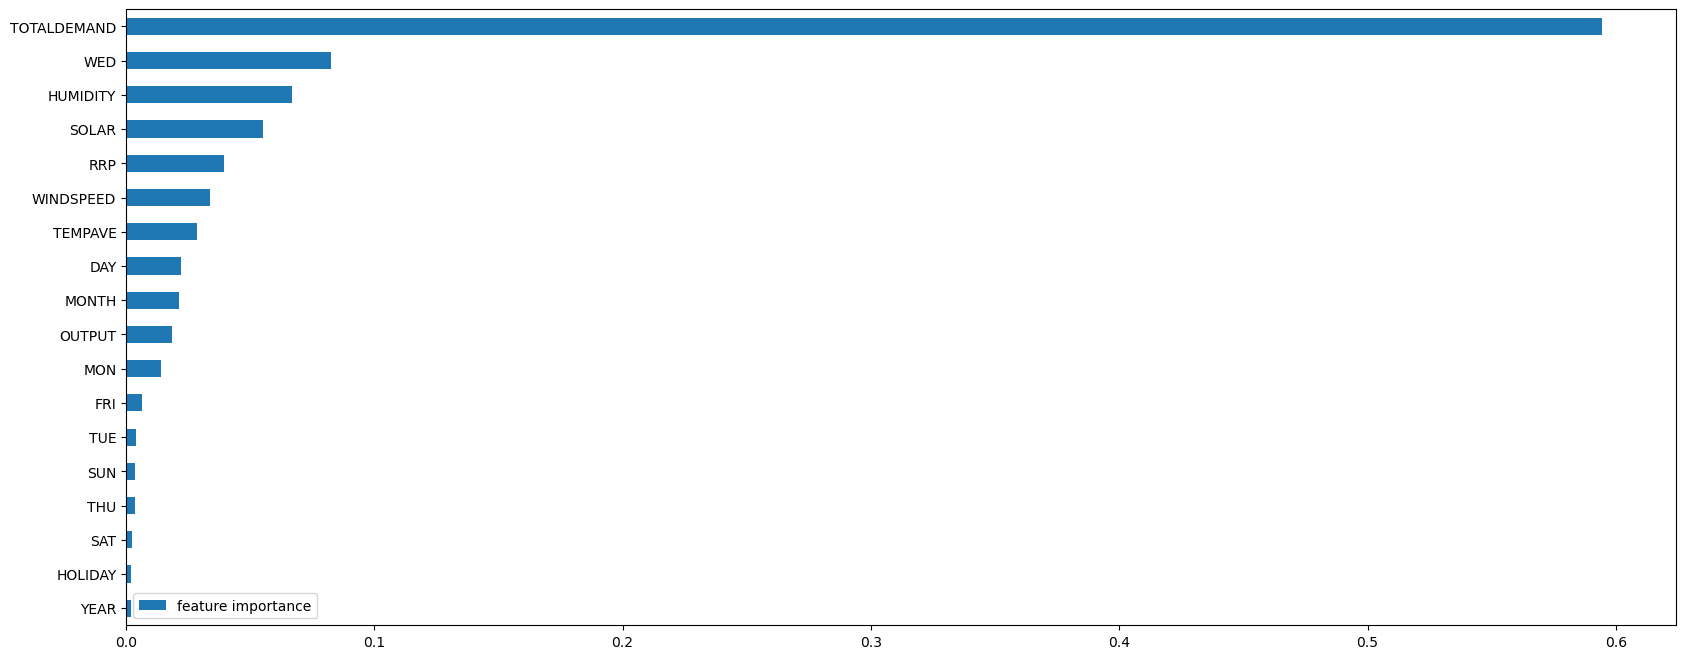

In [43]:
plt.rcParams["figure.figsize"] = (20,8)
feat_imp_df.sort_values(by='feature importance', ascending=True).plot.barh()

In [44]:
feat_imp_df.sort_values(by='feature importance', ascending=False)

,feature importance
TOTALDEMAND,0.594537
WED,0.082672
HUMIDITY,0.066858
SOLAR,0.055035
RRP,0.039454
WINDSPEED,0.033840
TEMPAVE,0.028401
DAY,0.022040
MONTH,0.021358
OUTPUT,0.018294
